# NIPBL
[Cornelia de Lange syndrome-1 (CDLS1)](https://omim.org/entry/122470) is caused by heterozygous mutation in the NIPBL gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1


## NIPBL
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for NIPBL.

In [2]:
gene_symbol = 'NIPBL'
mane_tx_id = 'NM_133433.4'
mane_protein_id = 'NP_597677.2' # nipped-B-like protein isoform A

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.22' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    cdls1_phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

print(f'Loaded {len(cdls1_phenopackets)} phenopackets ({gene_symbol}).')


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=cdls1_phenopackets, 
    cohort_creator=cohort_creator,
)

print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Loaded 60 phenopackets (NIPBL).
Individuals Processed: 100%|██████████| 60/60 [00:09<00:00,  6.62individuals/s]
Loaded 60 individuals
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Synophrys,HP:0000664,46
Global developmental delay,HP:0001263,42
Long eyelashes,HP:0000527,42
Microcephaly,HP:0000252,39
Intrauterine growth retardation,HP:0001511,39
Hirsutism,HP:0001007,39
Long philtrum,HP:0000343,37
Highly arched eyebrow,HP:0002553,36
Thin upper lip vermilion,HP:0000219,36
Downturned corners of mouth,HP:0002714,34


/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_46807/3591401028.py:7: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


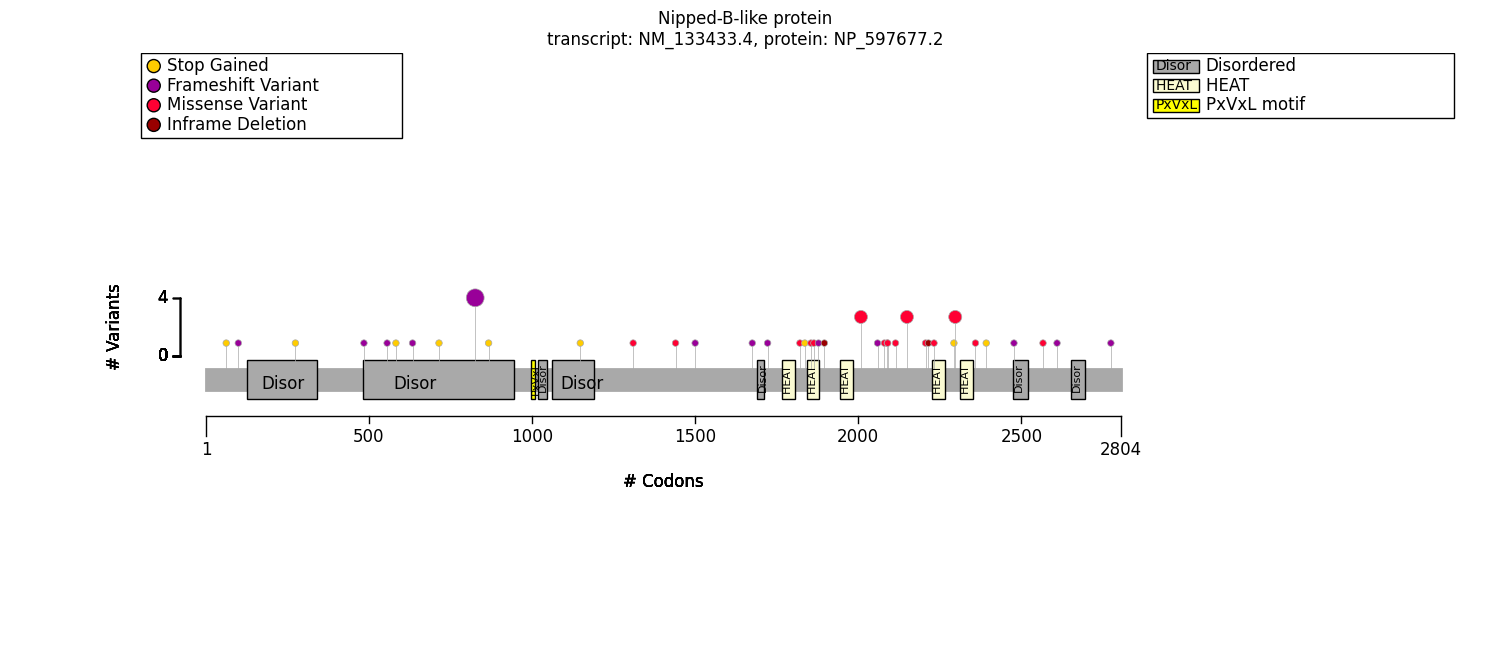

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

nipbl_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
nipbl_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Name,Type,Coordinates,Count,Variants
Disordered,REGION,128 - 340,1,p.Gln276Ter
Disordered,REGION,482 - 946,10,p.Arg868Ter; p.Glu487Ter; p.Thr558LeufsTer7; p.Ser635TyrfsTer3; p.Arg827GlyfsTer2; p.Gln716Ter; p.Asp584GlufsTer11; p.Arg827GlyfsTer20
PxVxL motif,MOTIF,996 - 1009,0,
Disordered,REGION,1017 - 1047,0,
Disordered,REGION,1060 - 1191,1,p.Arg1149Ter
Disordered,REGION,1691 - 1710,0,
HEAT 1,REPEAT,1767 - 1805,0,
HEAT 2,REPEAT,1843 - 1881,3,p.Arg1865Ser; p.Pro1880HisfsTer10; p.Arg1856Ile
HEAT 3,REPEAT,1945 - 1984,0,
HEAT 4,REPEAT,2227 - 2267,1,p.Val2233Met


# Genotype Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [ ]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
from gpsea.view import MtcStatsViewer

missense = VariantPredicates.variant_effect(effect=VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_predicate = monoallelic_predicate(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="missense",
    b_label="other"
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,30
HMF03,Skipping term because of a child term with the same individual counts,19
HMF08,Skipping general term,69
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,144


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense  ...          
                                                      Count  ...  p values
Small hand [HP:0200055]                                3/15  ...  0.005288
Hearing impairment [HP:0000365]                        3/13  ...  0.032361
Depressed nasal bridge [HP:0005280]                    6/13  ...  0.036714
Microcephaly [HP:0000252]                              9/13  ...  0.086669
Delayed speech and language development [HP:000...      6/9  ...  0.161851
...                                                     ...  ...       ...
Language impairment [HP:0002463]                        6/6  ...  1.000000
Abnormal communication [HP:0034434]                     6/6  ...  1.000000
Abnormal speech pattern [HP:0002167]                    6/6  ...  1.000000
Aplasia/Hypoplasia of the mandible [HP:0009118]         7/7  ...  1.000000
Intellectual disability [HP:0001249]                  10/12  ...  1.000000

[70 rows x 6 columns]

In [10]:
disordered = VariantPredicates.protein_feature(feature_id="Disordered", protein_metadata=protein_meta)

disordered_predicate = missense_predicate = monoallelic_predicate(
    a_predicate=disordered,
    b_predicate=~disordered,
    a_label="disordered",
    b_label="other"
)
disordered_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=disordered_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=disordered_result)

Allele group                                    disordered  ...          
                                                     Count  ...  p values
Intrauterine growth retardation [HP:0001511]         10/10  ...  0.050161
Curly eyelashes [HP:0007665]                           6/9  ...  0.122513
Single transverse palmar crease [HP:0000954]           5/5  ...  0.130085
Limited elbow extension [HP:0001377]                   4/6  ...  0.154142
Short stature [HP:0004322]                             4/6  ...  0.168956
...                                                    ...  ...       ...
Language impairment [HP:0002463]                       7/7  ...  1.000000
Abnormal communication [HP:0034434]                    7/7  ...  1.000000
Abnormal speech pattern [HP:0002167]                   7/7  ...  1.000000
Aplasia/Hypoplasia of the mandible [HP:0009118]        6/6  ...  1.000000
Intellectual disability [HP:0001249]                  9/10  ...  1.000000

[74 rows x 6 columns]

In [11]:
from gpsea.analysis.predicate.genotype import sex_predicate
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex                                                FEMALE  ...          
                                                    Count  ...  p values
Clinodactyly [HP:0030084]                            6/12  ...  0.038194
Finger clinodactyly [HP:0040019]                     5/11  ...  0.038444
Intrauterine growth retardation [HP:0001511]        17/19  ...  0.087457
Long eyelashes [HP:0000527]                         10/12  ...  0.104762
Micrognathia [HP:0000347]                           13/18  ...  0.134109
...                                                   ...  ...       ...
Delayed speech and language development [HP:000...  11/13  ...  1.000000
Language impairment [HP:0002463]                    11/11  ...  1.000000
Abnormal communication [HP:0034434]                 11/11  ...  1.000000
Abnormal speech pattern [HP:0002167]                11/11  ...  1.000000
Aplasia/Hypoplasia of the mandible [HP:0009118]     13/13  ...  1.000000

[67 rows x 6 columns]

# Summary

In [14]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


f_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_result
    ),
    GPAnalysisResultSummary.from_mono(
        result=disordered_result
    ),
    GPAnalysisResultSummary.from_mono(
        result=mf_result
    ),
)

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id)

In [15]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
missense,other,70,0
Genotype (A),Genotype (B),Tests performed,Significant tests
disordered,other,74,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,67,0


In [16]:
summarizer.process_latex(report=report, protein_fig=nipbl_fig)

Figure saved to ../../supplement/img/NIPBL_protein_diagram-draft.pdf
Output to ../../supplement/tex/NIPBL_summary_draft.tex
